In [11]:
import os, sys, glob, math, random
pi = math.pi
import matplotlib.pyplot as plt, numpy as np
from copy import copy
import shutil, pickle, cv2, imageio
from shapely.geometry import Polygon
from pyproj import Geod

# Define classes

## Forms classes

In [5]:
class Forms:
    """This parent class is created to give the two following functions to the different 
       children classes (forms)"""
    def draw(self):
        """This function draw the form as a polygon (shapely) 
           from the coordinates of its vertices. It will be used to compute the intersection
           of two forms"""
        t = Polygon(self.coordinate)
        return t
    
    def plot_(self):
        """Used to plot the polygons on a frame"""
        t = plt.Polygon(self.coordinate, color=self.color)
        return t
    
class Triangle(Forms):
    """A triangle is defined by the coordinate of its three sommets"""
    
    def __init__(self,x1,length, theta, color="red"):
        """Reparametrization x1,length,theta"""
        gamma = (2/3)*pi - theta
        self.x1 = x1
        self.x2 = length*math.cos(theta) + x1[0], length*math.sin(theta) + x1[1]
        self.x3 = x1[0] - length*math.cos(gamma), length*math.sin(gamma) + x1[1]
        self.coordinate = [self.x1,self.x2,self.x3]
        self.color = color

class Square(Forms):
    """A Square is defined by the coordinate of its 4 sommets"""
    
    def __init__(self,x1,length, theta,color="red"):
        """Reparametrization x1,length,theta"""
        gamma = (1/2)*pi - theta
        self.x1 = x1
        self.x2 = length*math.cos(theta) + x1[0], length*math.sin(theta) + x1[1]
        self.x3 =  self.x2[0] - length*math.sin(theta), length*math.cos(theta) + self.x2[1]
        self.x4 =x1[0] - length*math.cos(gamma), length*math.sin(gamma) + x1[1]
        self.coordinate = [self.x1,self.x2,self.x3,self.x4]
        self.color = color

## Frame class

In [6]:
class Frame:
    """This class is designed to combine a list of form to be rendered on the same frame/plot"""
    def __init__(self,forms):
        self.forms = {form.color: form for form in forms}
    def plot_(self,save=False,aspect=True):
        """Plot the frame with the given forms at the given coordinates"""
        figure, axes = plt.subplots()
        if aspect:
            axes.set_aspect(1)
            axes.set_axis_off()
        for color, form in self.forms.items():
            t_ = form.plot_()
            polygon = copy(t_)
            plt.gca().add_artist(polygon)
        if save:
            plt.savefig(save)
        else:
            plt.show()
    def get_pickled(self,filename):
        """To save the Frame object as a pickle file.
           In order to reuse it later"""
        filehandler = open(filename, 'wb') 
        pickle.dump(self, filehandler)

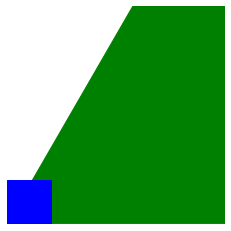

In [7]:
triangle =  Triangle((0,0),2,0,"green")
square = Square((0,0),0.2,0,color="blue")
frame = Frame([triangle, square])
frame.plot_()

# Comparator class

In [8]:
def PolyArea(poly_coord):
    """Compute the area of a polygon given its vertices coordinates.
       It involves the Shoelace formula.
       Reference :
       https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
       """
    if len(poly_coord)<1:
        return 0
    else:
        poly_coord = np.array(poly_coord)
        x, y = poly_coord[:,0], poly_coord[:,1]
        return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def segments2points(segment_list):
    """The intersection function of shapely returns a list of points and line2D,
    the line2D has to be unpacked into the two points it represents"""
    polygon_intersection = []
    for segment in segment_list:
        if "points" in dir(segment):
            # would be better to check the type rather than the attribut
            for point in segment.points:
                polygon_intersection.append((point.x,point.y))
        else:
            # because then the variable segment is a point
            polygon_intersection.append((segment.x,segment.y))
    return polygon_intersection

class Comparator:
    """This class is used to compare two frames according to the metrics"""
    def __init__(self, frame1, frame2):
        self.frame1 = frame1
        self.frame2 = frame2
        
    def compare_forms(self,coordinate1,coordinate2):
        """To compare forms of same color"""
        coordinate1 = [Point(coordinate) for coordinate in coordinate1]
        coordinate2 = [Point(coordinate) for coordinate in coordinate2]
        intersection = Polygon(*coordinate1).intersection(Polygon(*coordinate2))
        coordinates_intersection = segments2points(intersection)
        return PolyArea(coordinates_intersection)
    
    def compare(self):
        """Loop over the form of each frame to return the inv_dist
           between frame1"""
        inv_dist = 0
        for (color1, form1), (color2, form2) in zip(self.frame1.forms.items(),self.frame2.forms.items()):
            inv_dist += self.compare_forms(form1.coordinate, form2.coordinate)
        return inv_dist

# Order the frames

* Create n random frames in a directory
* Choose one frame from this directory
* Move it to a video directory with the index 0
* Delete it from the first directory
* Look for the image that maximises the distance
* Move the image to the video directory with the index 1
* Delete it from first directory
* Repeat this until no more images in the first directory
* Create the footage from the ordered frames in the video directory

In [10]:
def find_min_dist_frame(frame, directory):
    """From a given frame, this function look for the image that maximises
       the inverse of distance over all images of a directory"""
    max_dict = {}
    for filename in glob.glob(f'{directory}/*.obj'):
        filehandler = open(filename, 'rb')
        frame_load = pickle.load(filehandler)
        comparator = Comparator(frame,frame_load)
        inv_dist =  comparator.compare()
        max_dict[filename] = inv_dist
    return max(max_dict, key=max_dict.get)

## Create the different folders for the experiment

In [ ]:
folder_name = "moving_area"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
folder_video_name = f"video_{folder_name}"
if not os.path.exists(folder_video_name):
    os.makedirs(folder_video_name)

## Generate randomly frames
by generating random centers of forms. <br>
Frame objects are then all saved as pickle files.

In [ ]:
prefix = f"{folder_name}/{folder_name}"
n = 100
randomize_color = False
randomize_angle = True
for i in range(n):
    center_1 = random.random(), random.random()
    center_2 = random.random(), random.random()
    center_3 = random.random(), random.random()
    
    if randomize_angle:
        angle_1, angle_2 =  [2*pi*random.random() for i in range(2)]
    
    colors = ["blue","red","green"]
    if randomize_color:
        random.shuffle(colors)
        
    rndm_nb = random.random()
    square_size = rndm_nb*0.31
    triangle_size = (1-rndm_nb)*0.46
    
    square = Square(center_1,square_size,angle_1,color=colors[0])
    triangle =  Triangle(center_3,triangle_size,angle_2,colors[2])
    frame = Frame([square, triangle])
    
    # The frame object is saved as a pickle file for the later distance computations
    frame.get_pickled(filename=f"{prefix}_{i}.obj")

## Generate the videos

In [ ]:
# A seed frame is randomly chosen into the directory
seed_frame_path = random.choice(glob.glob(f'{folder_name}/*.obj'))
next_frame_path = seed_frame_path
index_loop = 0
# While there is still at least 2 images in the unordered directory
while len(os.listdir(folder_name)) > 1:
    # Move this image to the folder_video_name
    next_frame_path = shutil.move(next_frame_path, f"{folder_video_name}/{index_loop}.obj")
    # Increment the loop index
    index_loop+=1
    # Load the current frame
    filehandler = open(next_frame_path, 'rb')
    frame_n = pickle.load(filehandler)
    # Find the path of the min distance image
    next_frame_path = find_min_dist_frame(frame_n,folder_name)

## Create the videos from frames

In [ ]:
img_array = []
les_fichiers = glob.glob(f'{folder_video_name}/*.obj')
for index in range(len(les_fichiers)):
    filehandler = open(f'{folder_video_name}/{index}.obj', 'rb')
    frame = pickle.load(filehandler)
    frame.plot_(save="temp_image.png")
    img = cv2.imread(f"temp_image.png")
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
    
out = cv2.VideoWriter('project_carre_triangle_moving.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

## Convert the avi file to gif, to be rendered inside the jupyter nb
(and on the README.md on git)

In [21]:
# Reference : https://gist.github.com/michaelosthege/cd3e0c3c556b70a79deba6855deb2cc8

class TargetFormat(object):
    GIF = ".gif"
    MP4 = ".mp4"
    AVI = ".avi"

def convertFile(inputpath, targetFormat):
    """Reference: http://imageio.readthedocs.io/en/latest/examples.html#convert-a-movie"""
    outputpath = os.path.splitext(inputpath)[0] + targetFormat
    print("converting\r\n\t{0}\r\nto\r\n\t{1}".format(inputpath, outputpath))

    reader = imageio.get_reader(inputpath)
    fps = reader.get_meta_data()['fps']

    writer = imageio.get_writer(outputpath, fps=fps)
    for i,im in enumerate(reader):
        sys.stdout.write("\rframe {0}".format(i))
        sys.stdout.flush()
        writer.append_data(im)
    print("\r\nFinalizing...")
    writer.close()
    print("Done.")

convertFile("project_carre_triangle_moving.avi", TargetFormat.GIF)

converting
	project_carre_triangle_moving.avi
to
	project_carre_triangle_moving.gif
frame 99
Finalizing...
Done.


![](project_carre_triangle_moving.gif)